# BeKern Transposition Demo

This notebook demonstrates loading bekern notation from a .semantic file and using Verovio's transposition functionality.

---

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
import warnings
warnings.filterwarnings('ignore')

# Import existing demo utilities (same as luca_model_demo)
from utils import render_music_score, bekern_to_kern

print("Dependencies loaded successfully!")
print("Using the same rendering approach as luca_model_demo")

Dependencies loaded successfully!
Using the same rendering approach as luca_model_demo


## 2. Helper Functions

In [2]:
def load_bekern_file(file_path: str) -> str:
    """Load bekern notation from a .semantic file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            print(f"✅ Loaded BeKern file: {file_path}")
            print(f"Content length: {len(content)} characters")
            return content
    except Exception as e:
        print(f"❌ Error loading file {file_path}: {e}")
        return ""

def semantic_to_kern(semantic_content: str) -> str:
    """
    Convert semantic file content to proper Kern format.
    Semantic files are already in Kern structure but use · instead of . 
    """
    # Simply replace the middle dots with regular dots
    kern_content = semantic_content.replace('·', '.')
    
    # Replace **ekern_1.0 header with **kern
    kern_content = kern_content.replace('**ekern_1.0', '**kern')
    
    print("Converted semantic content to Kern format")
    print(f"Converted length: {len(kern_content)} characters")
    
    return kern_content

def render_with_transposition(kern_str: str, transpose_semitones: int = 0) -> Optional[np.ndarray]:
    """Render kern notation with optional transposition using Verovio."""
    try:
        import verovio
        import cv2
        import cairosvg
        
        tk = verovio.toolkit()
        
        # Set options with transposition if specified
        options = {
            "pageWidth": 2100,
            "scale": 40,
            "adjustPageHeight": True,
            "footer": "none",
            "header": "none"
        }
        
        if transpose_semitones != 0:
            options["transpose"] = str(transpose_semitones)
        
        tk.setOptions(options)
        tk.loadData(kern_str)
        svg = tk.renderToSVG()
        
        # Convert SVG to PNG
        png_data = cairosvg.svg2png(bytestring=svg.encode('utf-8'), background_color='white')
        image_array = cv2.imdecode(np.frombuffer(png_data, np.uint8), -1)
        return cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        
    except Exception as e:
        print(f"Error in transposition rendering: {e}")
        return None

def display_comparison(original_img, transposed_img, transpose_amount):
    """Display side-by-side comparison of original and transposed notation."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    if original_img is not None:
        axes[0].imshow(original_img)
        axes[0].set_title("Original Notation", fontsize=14)
    else:
        axes[0].text(0.5, 0.5, 'Rendering\nFailed', ha='center', va='center', 
                    transform=axes[0].transAxes)
        axes[0].set_title("Original Notation (Failed)", fontsize=14)
    
    if transposed_img is not None:
        axes[1].imshow(transposed_img)
        direction = "Up" if transpose_amount > 0 else "Down"
        axes[1].set_title(f"Transposed {abs(transpose_amount)} Semitones {direction}", fontsize=14)
    else:
        axes[1].text(0.5, 0.5, 'Rendering\nFailed', ha='center', va='center', 
                    transform=axes[1].transAxes)
        axes[1].set_title(f"Transposed {abs(transpose_amount)} Semitones (Failed)", fontsize=14)
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 3. Configuration

In [3]:
# Configuration
SEMANTIC_FILE_PATH = "/home/stud/wiel/music_recognition/data/datasets/smt_datasets/camera-grandstaff/test/sample_000000/sample_000000.semantic"
TRANSPOSE_SEMITONES = 5  # Positive = up, negative = down

## 4. Load BeKern File

In [4]:
# Load bekern file
bekern_content = load_bekern_file(SEMANTIC_FILE_PATH)

✅ Loaded BeKern file: /home/stud/wiel/music_recognition/data/datasets/smt_datasets/camera-grandstaff/test/sample_000000/sample_000000.semantic
Content length: 438 characters


## 5. Convert to Kern Format

In [5]:
# Convert semantic content to kern format (not using bekern_to_kern which is for model output)
kern_notation = semantic_to_kern(bekern_content)

Converted semantic content to Kern format
Converted length: 428 characters


## 6. Render Comparison with Transposition

**Transposition**: Positive numbers transpose up, negative transpose down. Common intervals:
- 1=minor 2nd, 2=major 2nd, 3=minor 3rd, 5=perfect 4th, 7=perfect 5th, 12=octave

Rendering original and transposed music scores...


Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'i1dao8ks'.
[Warning] tie 'tie-L33F2-L35F2' is ignored, since start 'note-L33F2' does not occur temporally before end 'k1tiyuri'.
Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'n16zzqqx'.
[Warning] tie 'tie-L33F2-L35F2' is ign

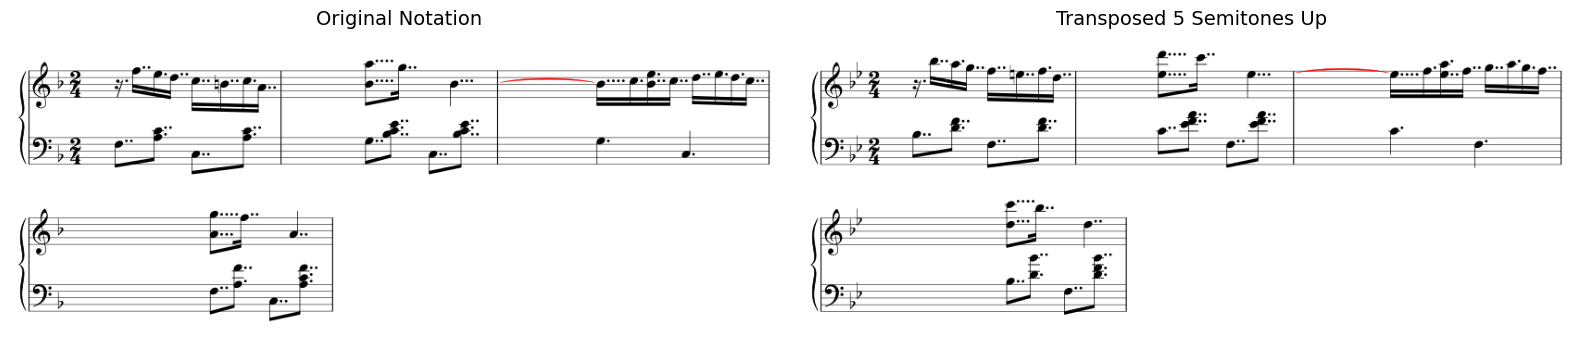

✅ Original score rendered successfully
✅ Transposed score (+5 semitones) rendered successfully


In [6]:
# Render both original and transposed versions
if 'kern_notation' in locals():
    print("Rendering original and transposed music scores...")
    
    try:
        # Render original (no transposition)
        original_image = render_with_transposition(kern_notation, 0)
        
        # Render transposed version
        transposed_image = render_with_transposition(kern_notation, TRANSPOSE_SEMITONES)
        
        # Display side-by-side comparison
        display_comparison(original_image, transposed_image, TRANSPOSE_SEMITONES)
        
        # Also show individual results
        if original_image is not None:
            print("✅ Original score rendered successfully")
        else:
            print("❌ Original score rendering failed")
            
        if transposed_image is not None:
            print(f"✅ Transposed score (+{TRANSPOSE_SEMITONES} semitones) rendered successfully")
        else:
            print(f"❌ Transposed score (+{TRANSPOSE_SEMITONES} semitones) rendering failed")
            
    except Exception as e:
        print(f"❌ Error during rendering: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Cannot render: Kern notation not available.")

In [7]:
# Test multiple transpositions
print("Testing multiple transposition values...")
test_values = [-7, -5, -3, -1, 0, 1, 3, 5, 7, 12]

for transpose_val in test_values:
    result = render_with_transposition(kern_notation, transpose_val)
    status = "✅" if result is not None else "❌"
    print(f"{transpose_val:+3d} semitones: {status}")

print("\nTransposition testing complete!")

Testing multiple transposition values...
 -7 semitones: ✅


Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'a1q5d204'.
[Warning] tie 'tie-L33F2-L35F2' is ignored, since start 'note-L33F2' does not occur temporally before end 'c1pfc8bw'.
Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'j1r3rez7'.
[Warning] tie 'tie-L33F2-L35F2' is ign

 -5 semitones: ✅
 -3 semitones: ✅


Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'c4k6nkq'.
[Warning] tie 'tie-L33F2-L35F2' is ignored, since start 'note-L33F2' does not occur temporally before end 'ef7l17d'.
Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 't5uu1ld'.
[Warning] tie 'tie-L33F2-L35F2' is ignore

 -1 semitones: ✅
 +0 semitones: ✅


Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'r1degpz5'.
[Warning] tie 'tie-L33F2-L35F2' is ignored, since start 'note-L33F2' does not occur temporally before end 't27g80m'.
Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'e145769z'.
[Warning] tie 'tie-L33F2-L35F2' is igno

 +1 semitones: ✅
 +3 semitones: ✅


Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'jorj5cu'.
[Warning] tie 'tie-L33F2-L35F2' is ignored, since start 'note-L33F2' does not occur temporally before end 'l5oqj6c'.
Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'q1yhubb6'.
[Warning] tie 'tie-L33F2-L35F2' is ignor

 +5 semitones: ✅
 +7 semitones: ✅


Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'z1wpw3x1'.
[Warning] tie 'tie-L33F2-L35F2' is ignored, since start 'note-L33F2' does not occur temporally before end 'bvexcdj'.
Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'q1mtdskj'.
[Warning] tie 'tie-L33F2-L35F2' is igno

+12 semitones: ✅

Transposition testing complete!


## 7. Test Multiple Transpositions

Test various transposition intervals to verify functionality.

## 8. Interactive Testing

Change the transposition value and re-run to test different intervals.

Testing transposition: +7 semitones


Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'kuar4hn'.
[Warning] tie 'tie-L33F2-L35F2' is ignored, since start 'note-L33F2' does not occur temporally before end 'm1on2k0p'.
Error: Inconsistent rhythm analysis occurring near line 8
Expected durationFromStart to be: 13/16 but found it to be 7/8
Line: 8.c.J 8.A	16.ee

[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] In HumdrumInput::setDuration: Unprintable duration11/32 quarter notes
[Warning] tie 'tie-L18F2-L20F2' is ignored, since start 'note-L18F2' does not occur temporally before end 'l1y19pbw'.
[Warning] tie 'tie-L33F2-L35F2' is igno

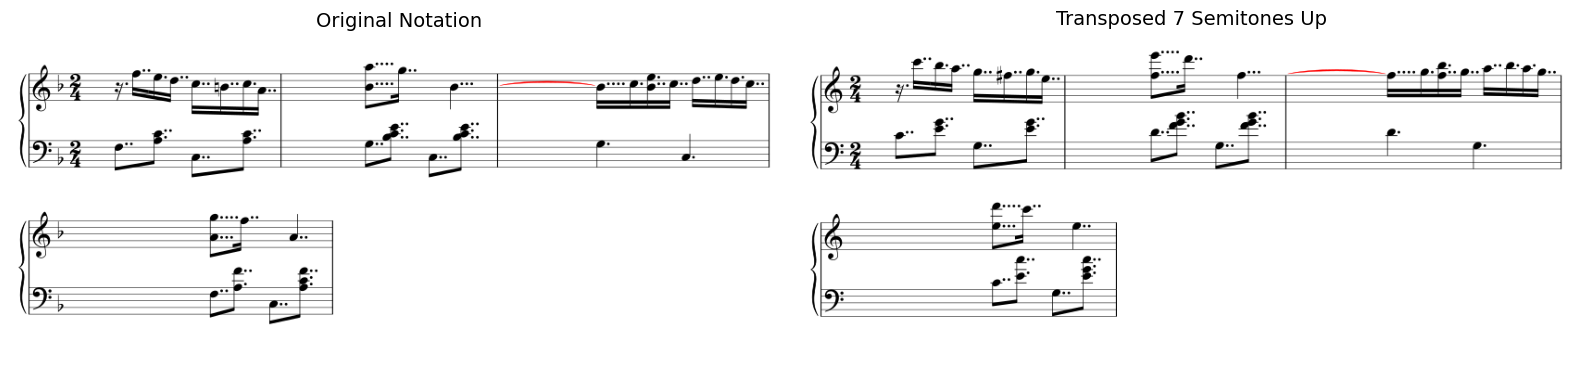

In [8]:
# Interactive testing - change this value and re-run the cell
CUSTOM_TRANSPOSE = 7  # Change this to test different transpositions

print(f"Testing transposition: {CUSTOM_TRANSPOSE:+d} semitones")

# Render and display
custom_original = render_with_transposition(kern_notation, 0)
custom_transposed = render_with_transposition(kern_notation, CUSTOM_TRANSPOSE)
display_comparison(custom_original, custom_transposed, CUSTOM_TRANSPOSE)